In [2]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from funcs_support import area_mean

In [3]:
dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()

In [4]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)

In [5]:
#get the temperature variable and all GWLs from the dataframe 
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()

In [6]:
#check the GWLs included in the data 
ds_check = xr.open_zarr(df['path'].iloc[0])
print(ds_check['bins_behrer'].coords['gwl'].values)

[0.61 1.   1.5  2.   2.5  3.  ]


In [7]:
#this function rebins the mortality dmgf according to the bins used in the temperature df
def rebin_temp_data_mortality(da):
    
    #creates new edges of the bins from >10, 10-100, <100, in intervals of 10F. Then, calculate the midpoints of the bins 
    edges_F = np.concatenate(([-np.inf], np.arange(10, 100, 10), [np.inf]))
    mid_F = (edges_F[:-1] + edges_F[1:]) / 2
    
    mort_coeffs = [0.69,0.59,0.64,0.36,0.27,0.00,0.12,0.23,0.33,0.94]
    
    #creates an array with the mortality coeffs, and labels the 1D dim 'bin10F'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in farenheit. Names the array.
    dmgf_10F = xr.DataArray(mort_coeffs, dims=['bin10F'], coords={'bin10F':np.arange(10), 'mid_F_degF': ('bin10F', mid_F)},
    name='mortality_coeff')
    
    #grabs bins from ds and converts to F
    hist_bins_F = da['bin_f'].values * 9/5 - 459.67
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_F, edges_F) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin10F dimension the coeff that matches the integer 
        #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_10F.sel(bin10F = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine

In [8]:
#this function rebins the gdp dmgf according to the bins used in the temperature df
def rebin_temp_data_gdp(da):
    
    #creates new edges of the bins from >-15, -15-31, <31, in intervals of 3C. Then, calculate the midpoints of the bins 
    edges_C = np.concatenate(([-np.inf], np.arange(-15, 31, 3), [ np.inf ]))
    mid_C   = (edges_C[:-1] + edges_C[1:]) / 2
    
    gdp_coeffs = [0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                    0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757]
    
    #creates an array with the gdp coeffs, and labels the 1D dim 'bin3C'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in C. Names the array.
    dmgf_dnh_3C = xr.DataArray(gdp_coeffs,dims=['bin3C'],coords={'bin3C':np.arange(len(gdp_coeffs)),'mid_C_degC': ('bin3C', mid_C)},name='gdp_loss_coeff')

    #grabs bins from ds and converts to C
    hist_bins_C = da['bin_f'].values - 273.15
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_C, edges_C) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin3C dimension the coeff that matches the integer 
    #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_dnh_3C.sel(bin3C = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine

In [9]:
#calculates the impact (either in terms of mortality or GDP percent change) for each additional day 
#spent in a given temperature bin at the grid cell level, with gwl as the input. Thus, calculates a
#map of impacts over CONUS at the grid-cell level.
def calculate_impact(gwl):
    mort_impact_list = []
    gdp_impact_list  = []
    model_labels     = []
    run_labels       = []

    #iterates through each entry and row in the dataframe containing temperature data, and finds the 
    #change in the number of days at GWL 0.61 and the input gwl. The impact functions are rebinned
    #according to the temperature data, and the difference in days in each bin is multiplied by the 
    #imapct coefficeint. These impacts are then added to the empty lists created above, and concatenated
    #on a run dimension.
    for i, row in df.iterrows():
        model_labels.append(row['model'])
        run_labels.append(row['run'])
    
        ds = xr.open_zarr(row['path'])
        
        gwl_delta = ds['bins_behrer'].interp(gwl=gwl).transpose('bin_f','lat','lon')
        gwl_06    = ds['bins_behrer'].interp(gwl=0.61).transpose('bin_f','lat','lon')

        diff = gwl_delta - gwl_06
    
        # mortality
        mort_coef_fine = rebin_temp_data_mortality(diff)
        mort_map = (diff * mort_coef_fine).sum(dim='bin_f', skipna = False)
        mort_impact_list.append(mort_map)

        # GDP‐loss
        gdp_coef_fine = rebin_temp_data_gdp(diff)
        gdp_map_ln = (diff * gdp_coef_fine).sum(dim="bin_f", skipna=False)
        
        gdp_all_pct = (np.exp(gdp_map_ln) - 1) * 100
        gdp_all_pct = gdp_all_pct.compute()
        

        gdp_impact_list.append(gdp_all_pct)
        
    mort_all = xr.concat(mort_impact_list, dim='run')
    gdp_all  = xr.concat(gdp_impact_list,  dim='run')
    mort_all = mort_all.assign_coords({'run': run_labels,'model': ('run', model_labels)})
    gdp_all  = gdp_all.assign_coords({'run':   run_labels,'model': ('run', model_labels)}) 
    
    return mort_all, gdp_all

In [10]:
def variability_partitioning(impact_all):
    impact_all = impact_all.where(impact_all != 0)
    
    #this finds the internal variability within each model over different runs
    within_model_var = impact_all.groupby('model').var(dim='run',  skipna=True, ddof=0)
    #finds mean internal variability over the dimension model (i.e. mean internal var across models)
    internal_var = within_model_var.mean(dim='model',  skipna=True)
    
    #this finds the mean impacts by model, for each run 
    model_means = impact_all.groupby('model').mean(dim='run', skipna=True)
    #this finds the variance in model means across models (i.e. model uncertainty)
    model_unc = model_means.var(dim='model', skipna=True, ddof = 0)

    #calculates total variability as the sum of internal and model uncertainty
    total_var = internal_var + model_unc

    #gets fractional internal and model uncertainty, making sure to avoid dividing by zeros
    f_internal = xr.where(total_var > 0,internal_var / total_var,0.0)
    f_model = xr.where(total_var > 0,model_unc / total_var,0.0)
    
    return xr.Dataset({
        "internal_variance": internal_var,
        "model_unc": model_unc,
        "total_variance": total_var,
        "f_internal": f_internal,
        "f_model": f_model
    })


In [12]:
#simple map plotting function, plots CONUS with borders, using the reds colorscale
def plot_map(data, title, cbar_label):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': cbar_label})
    ax.coastlines()
    ax.set_title(title)
    plt.show()

In [11]:
#plots the fractional uncertainty in mortality impacts over the US, and calculates a shared colorbar for model and internal 
#variability, setting the minimum as the minimum between internal and model uncertainty, and likewise 
#for the maximum. Plots two columns, the right shows model uncertainty, and the left internal variability.
def plot_mortality_panels(ensemble_mort, mort_stats, gwl):
    iv = mort_stats['internal_variance']
    mv = mort_stats['model_unc']
    
    iv_min = iv.min().compute().item()
    mv_min = mv.min().compute().item()
    iv_max = iv.max().compute().item()
    mv_max = mv.max().compute().item()

    vmin = min(iv_min, mv_min)
    vmax = max(iv_max, mv_max)
    
    plot_map(ensemble_mort, f"Ensemble Mean Δ Mortality\n(0.61→{gwl}°C)", "Δ deaths per 100 k")
    
    fig, axes = plt.subplots(1, 2,figsize=(18, 6),subplot_kw={'projection': ccrs.PlateCarree()})

    ax = axes[0]
    iv.plot(ax=ax, cmap='Reds',vmin=vmin, vmax=vmax,cbar_kwargs={'label': 'Variance (deaths per 100 k)'})
    ax.coastlines()
    ax.set_title("Internal Variability")

    ax = axes[1]
    mv.plot(ax=ax, cmap='Reds',vmin=vmin, vmax=vmax,cbar_kwargs={'label': 'Variance (deaths per 100 k)'})
    ax.coastlines()
    ax.set_title("Model Uncertainty")

    plt.tight_layout()
    plt.show()


In [13]:
#likewise, plots the fractional uncertainty in gdp impacts over the US, and calculates a shared colorbar for model and internal 
#variability, setting the minimum as the minimum between internal and model uncertainty, and likewise 
#for the maximum. Plots two rows, the top shows model uncertainty, and the bottom internal variability.
def plot_gdp_panels(ensemble_gdp, gdp_stats, gwl):
    iv = gdp_stats['internal_variance']
    mv = gdp_stats['model_unc']
    
    iv_min = iv.min().compute().item()
    mv_min = mv.min().compute().item()
    iv_max = iv.max().compute().item()
    mv_max = mv.max().compute().item()

    vmin = min(iv_min, mv_min)
    vmax = max(iv_max, mv_max)
   
    plot_map(ensemble_gdp, f"Ensemble Mean GDP % Change (0.61→{gwl}°C)", "% change in GDP per capita")
  
    fig, axes = plt.subplots(1, 2,figsize=(18, 6),subplot_kw={'projection': ccrs.PlateCarree()})

    ax = axes[0]
    iv.plot(ax=ax, cmap='Reds',vmin=vmin, vmax=vmax,cbar_kwargs={'label': "Variance (% change)"})
    ax.coastlines()
    ax.set_title(f"Internal Variability (GDP) at {gwl}°C")

    ax = axes[1]
    mv.plot(ax=ax, cmap='Reds',vmin=vmin, vmax=vmax,cbar_kwargs={'label': "Variance (% change)"})
    ax.coastlines()
    ax.set_title(f"Model Uncertainty (GDP) at {gwl}°C")

    plt.tight_layout()
    plt.show()


In [14]:
#This "spit out" function plots total impacts for GDP and mortality over the CONUS for each GWL,
#as well as the maps of fractional variance for each GWL
def spit_out(gwl):
    mort_all, gdp_all_pct = calculate_impact(gwl)
    
    ensemble_mort = mort_all.mean(dim='run')
    ensemble_gdp  = gdp_all_pct.mean(dim='run')

    mort_stats = variability_partitioning(mort_all)
    gdp_stats  = variability_partitioning(gdp_all_pct)

    plot_mortality_panels(ensemble_mort, mort_stats, gwl)
    plot_gdp_panels(ensemble_gdp, gdp_stats, gwl)
    
    return {
        'mort_all':      mort_all,
        'gdp_all':       gdp_all_pct,
        'ensemble_mort': ensemble_mort,
        'ensemble_gdp':  ensemble_gdp,
        'mort_stats':    mort_stats,
        'gdp_stats':     gdp_stats
    }


/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


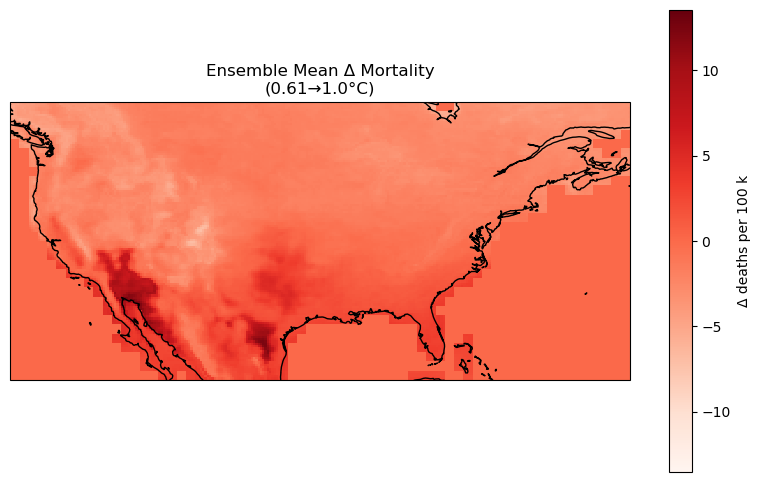

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


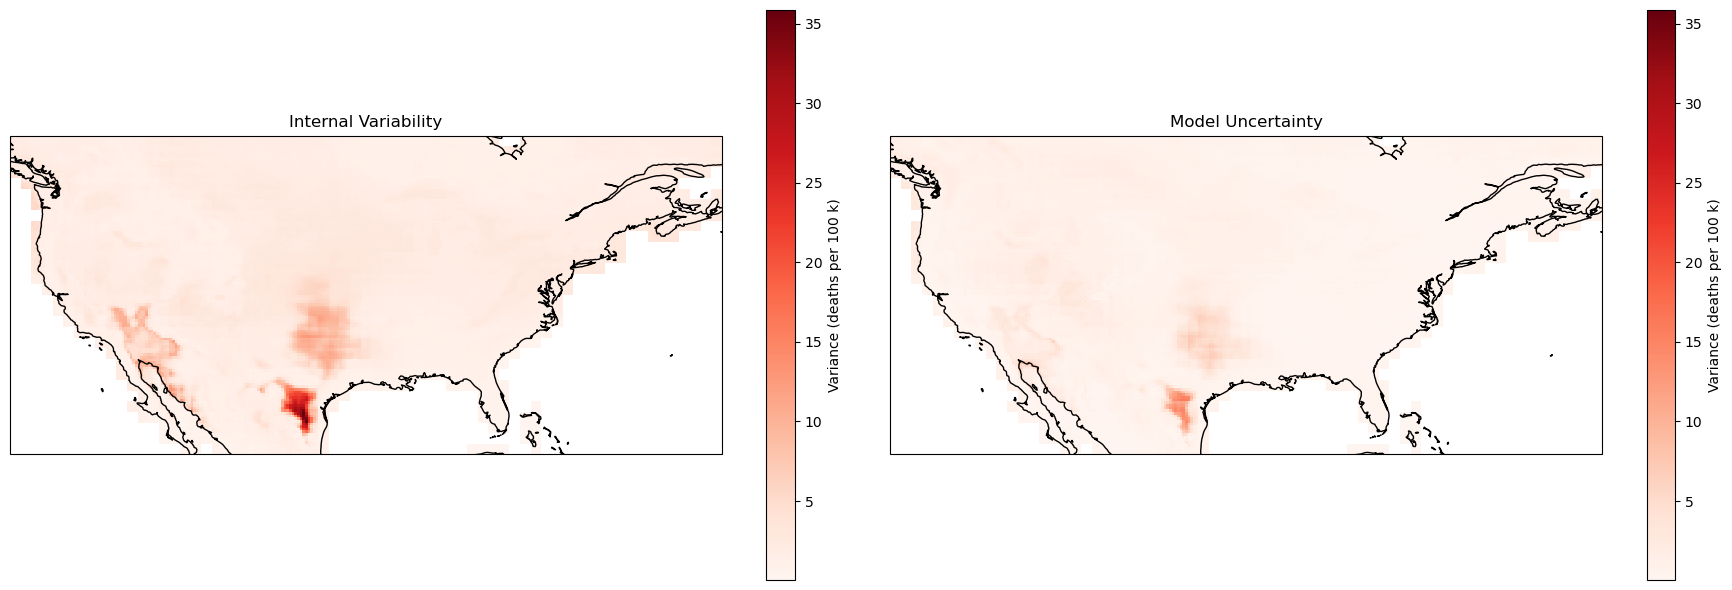

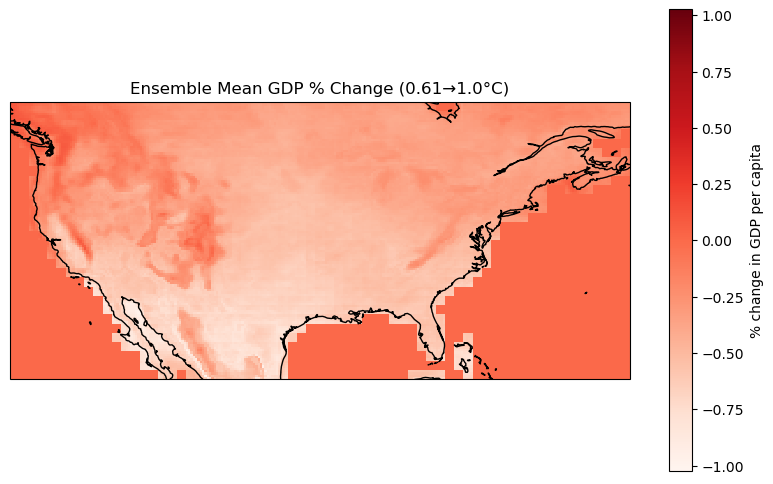

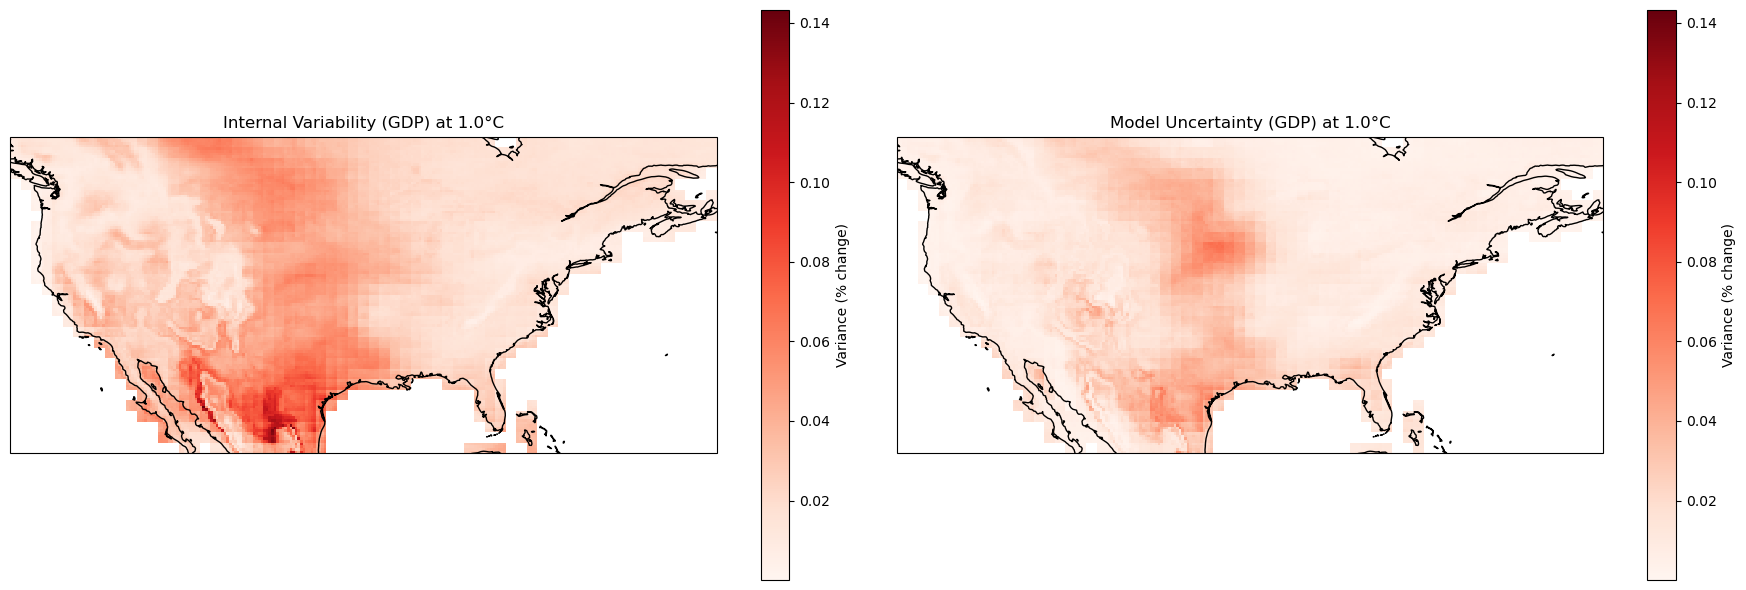

In [79]:
results_1 = spit_out(1.0)

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


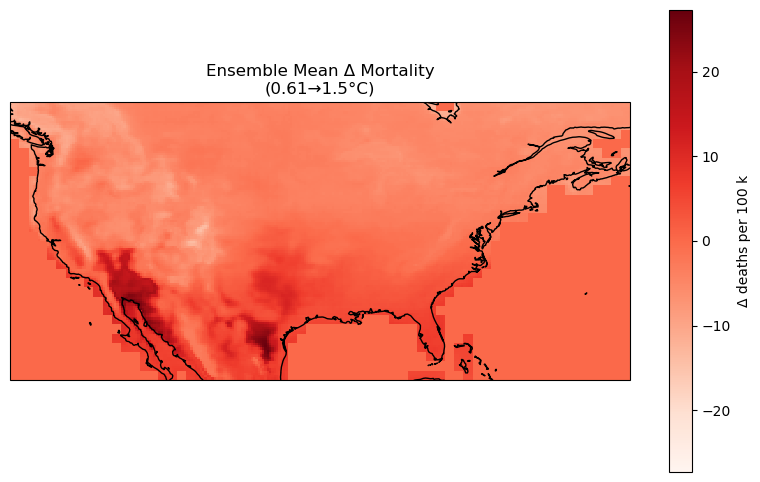

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


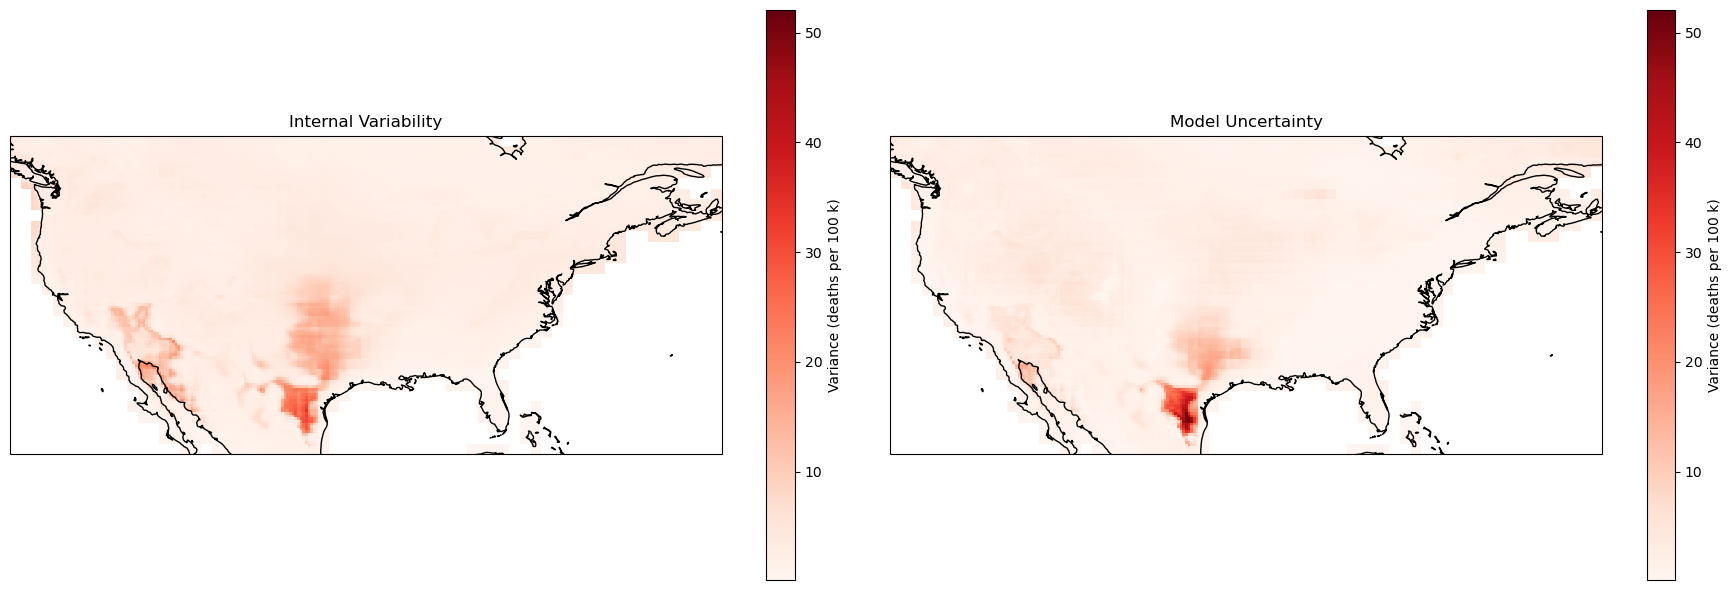

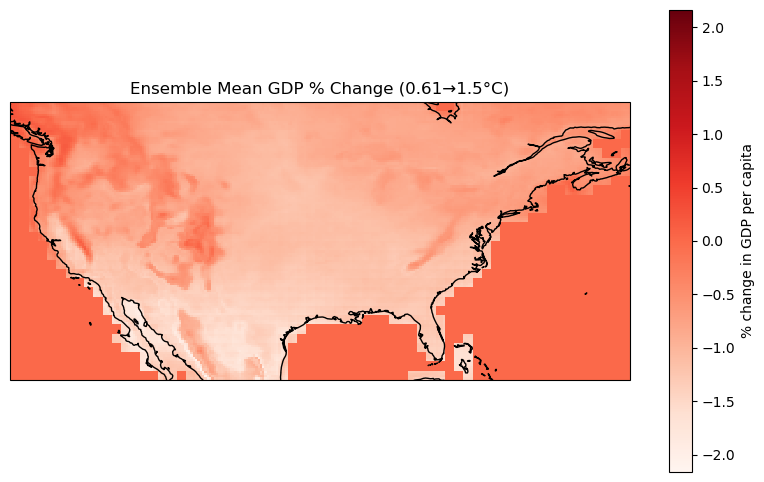

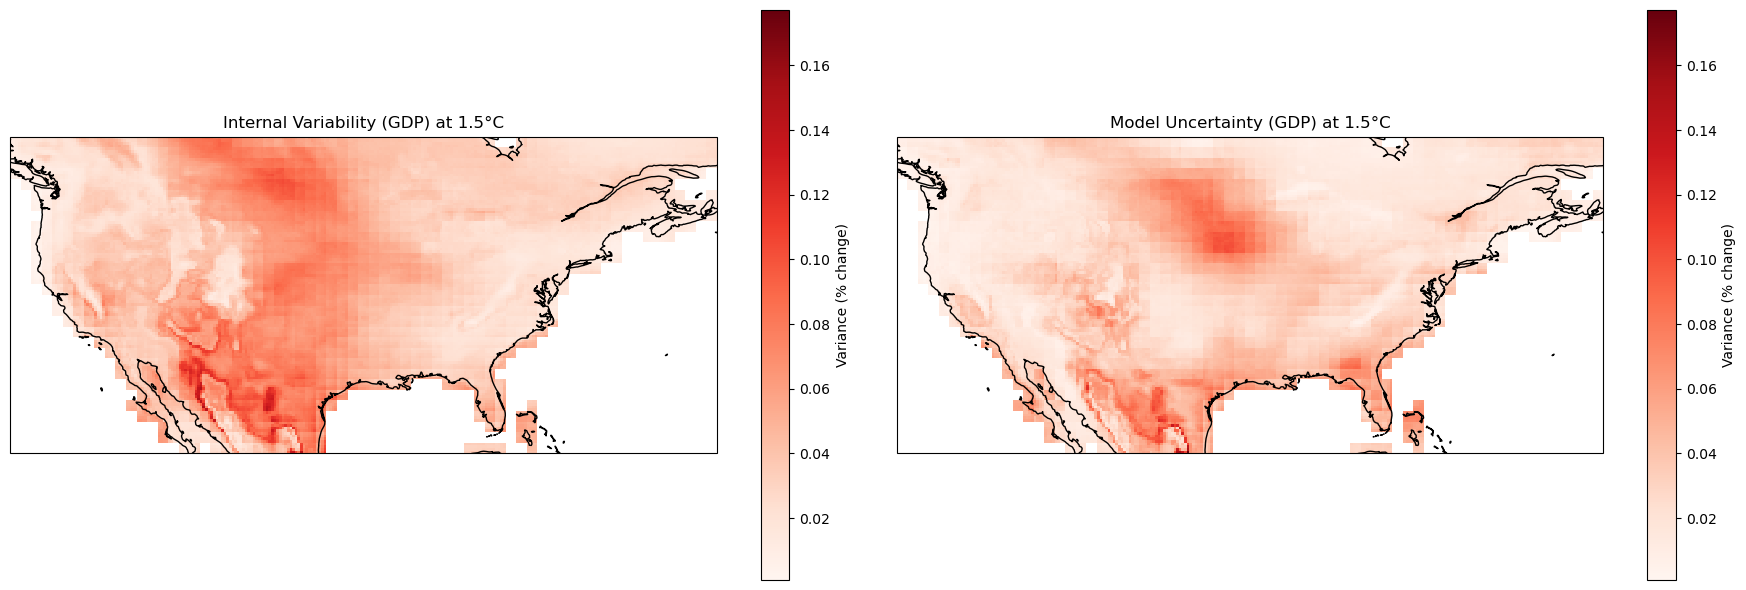

In [80]:
results_15 = spit_out(1.5)

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


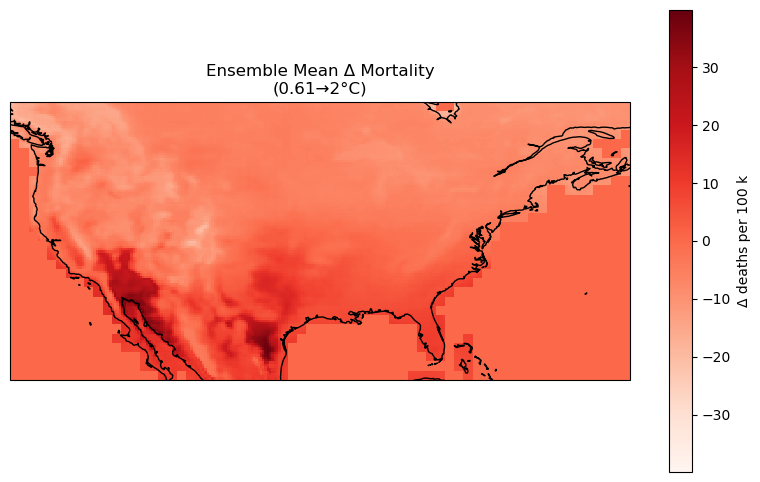

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


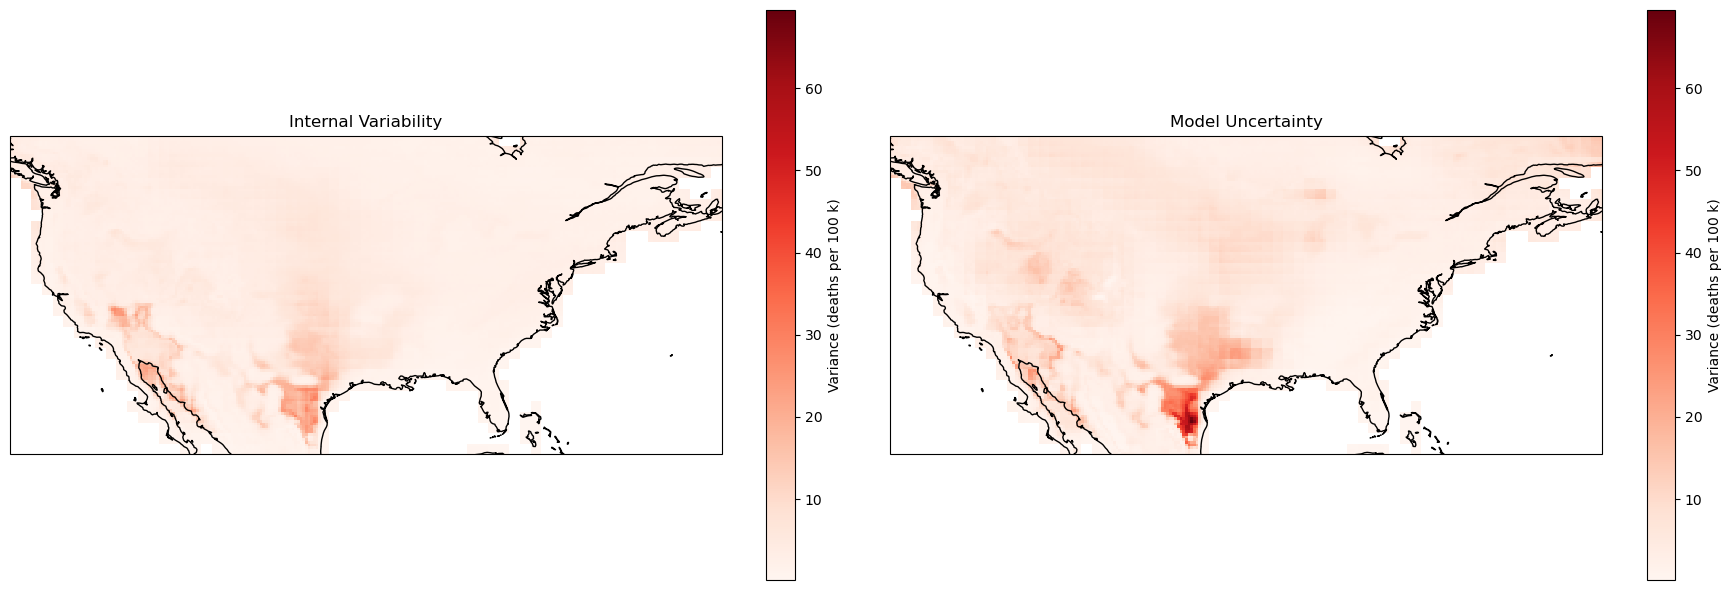

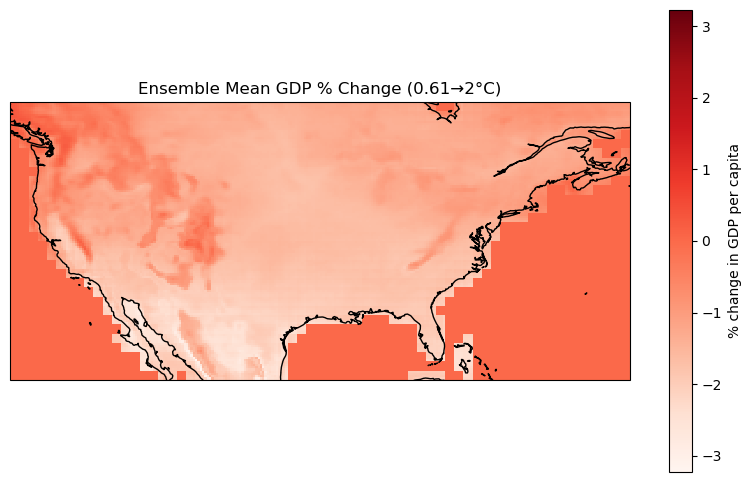

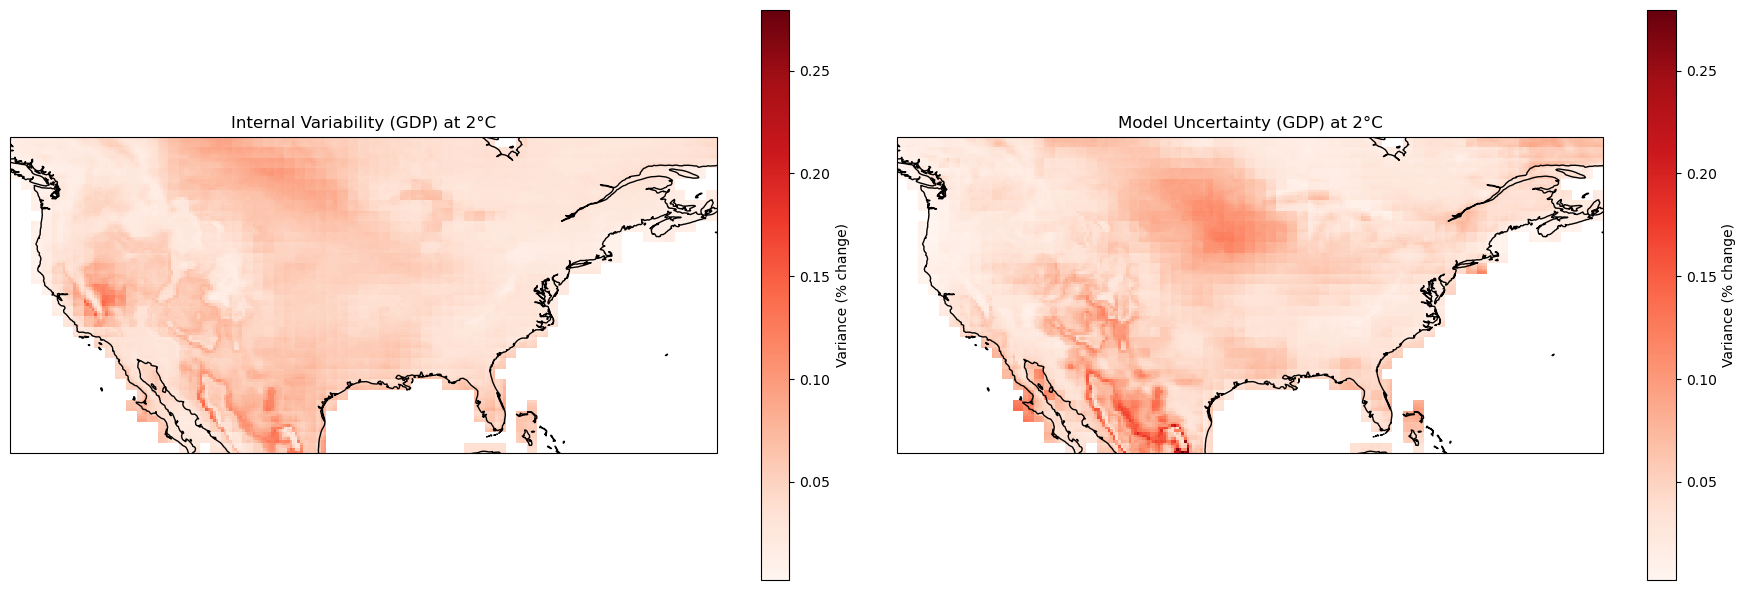

In [81]:
results_2 = spit_out(2)

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


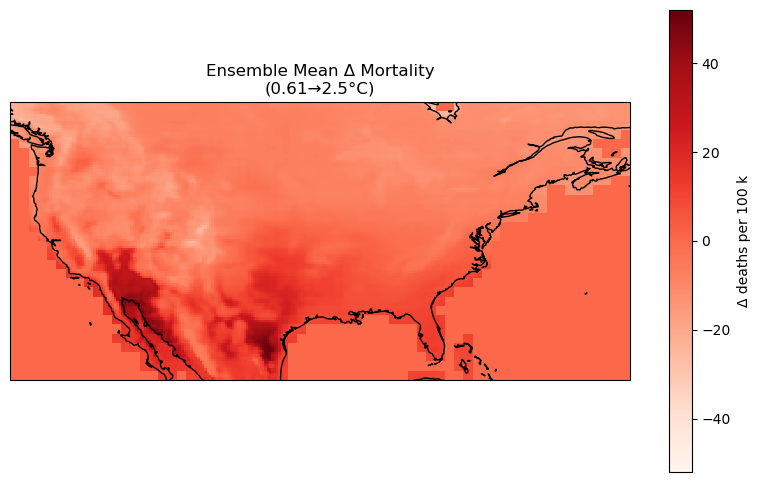

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


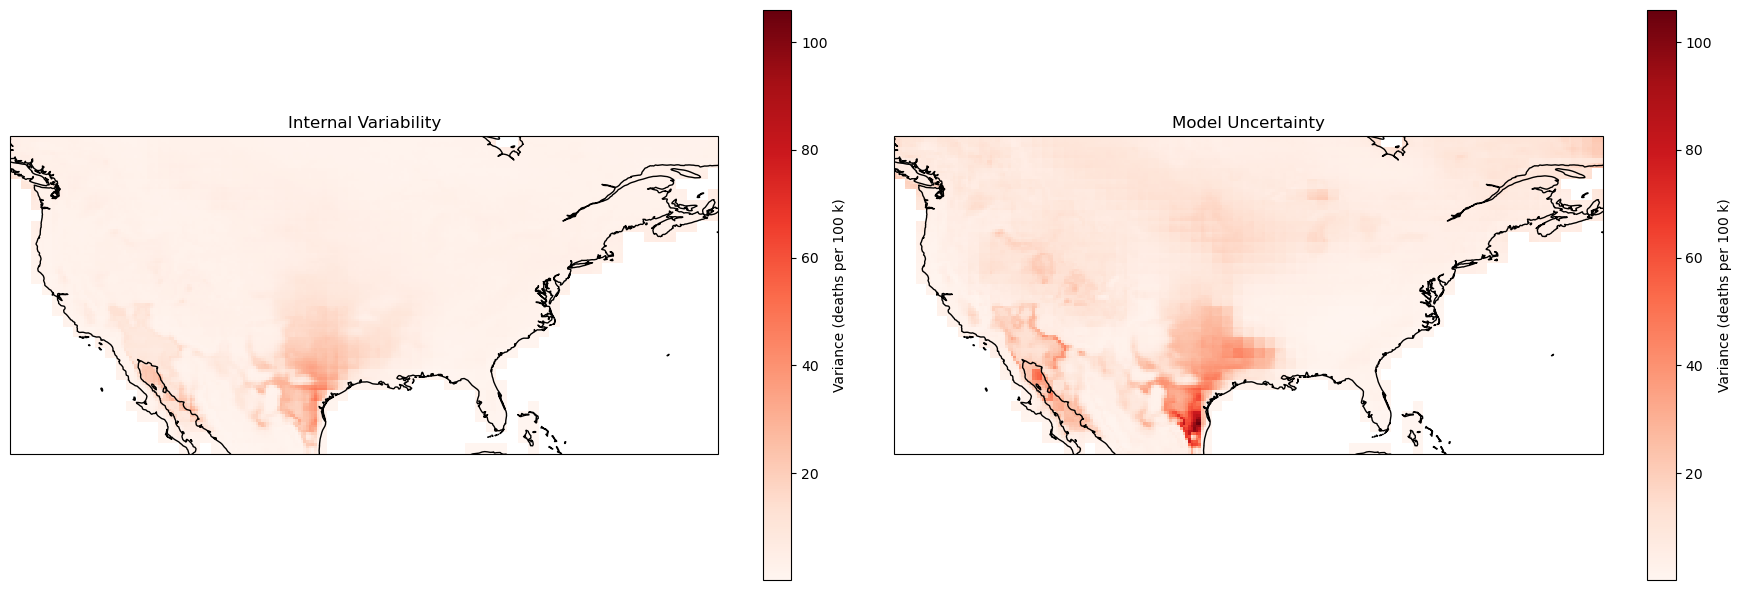

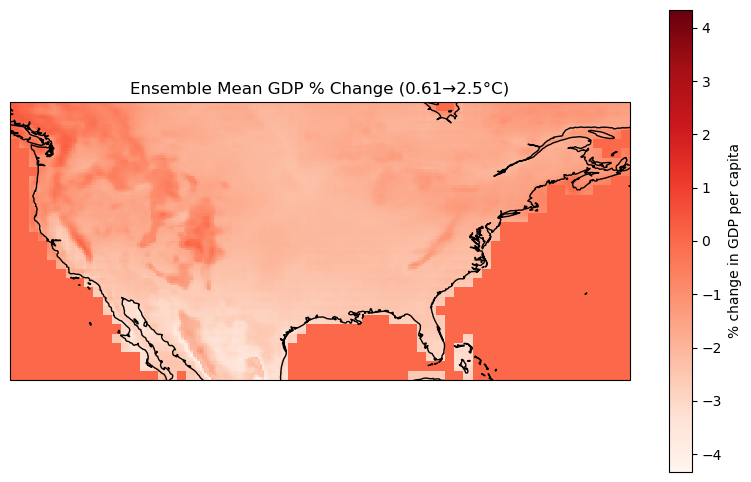

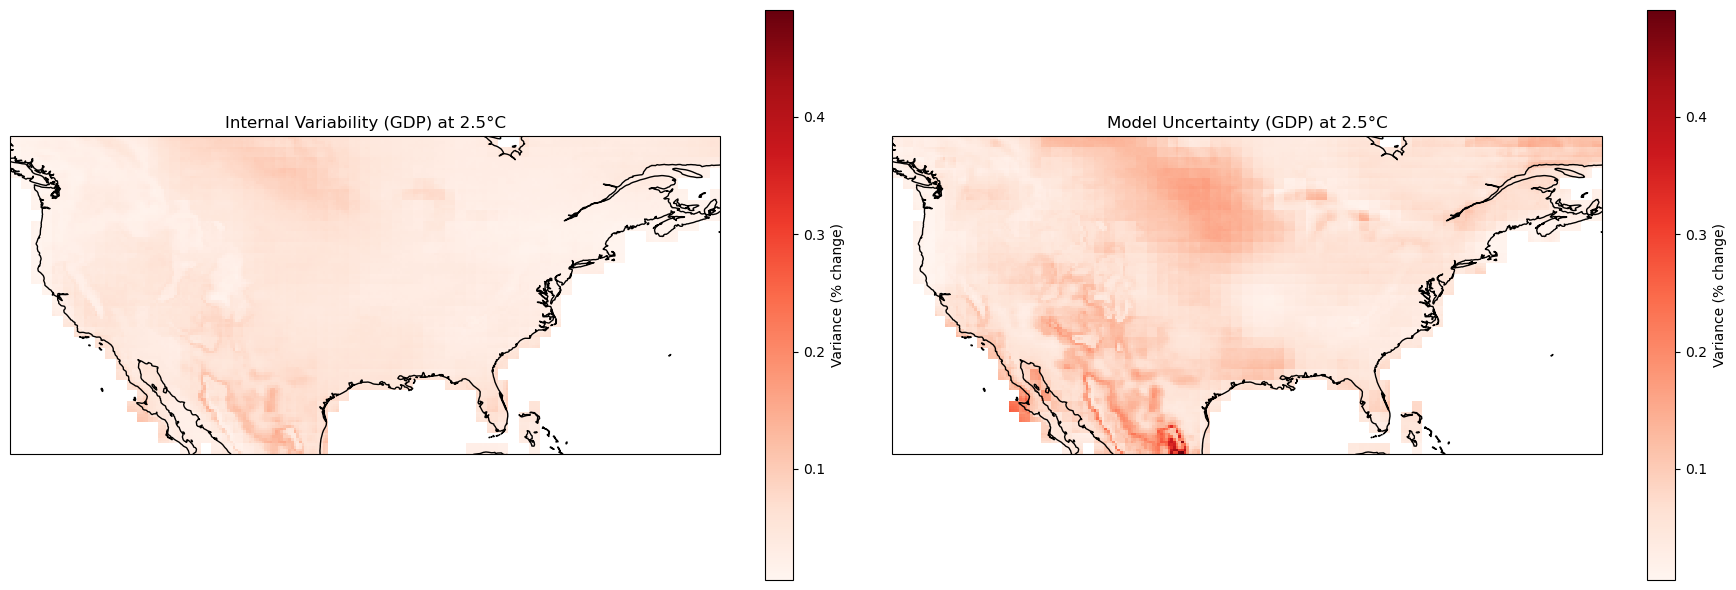

In [82]:
results_25 = spit_out(2.5)

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


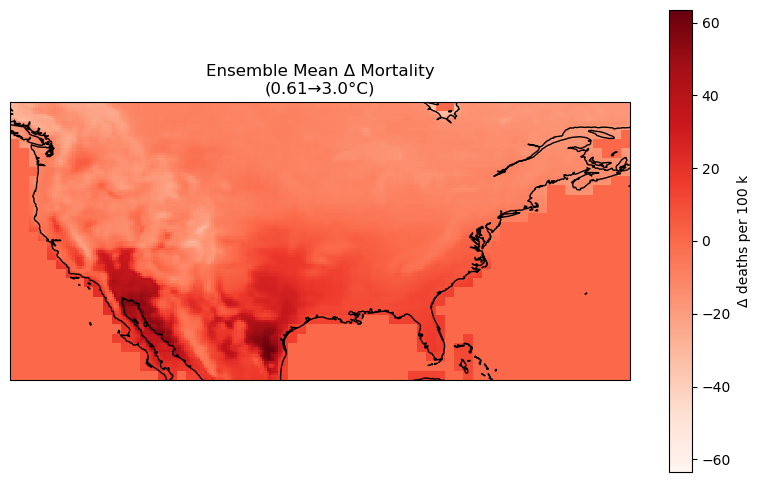

/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/apps/anaconda3/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


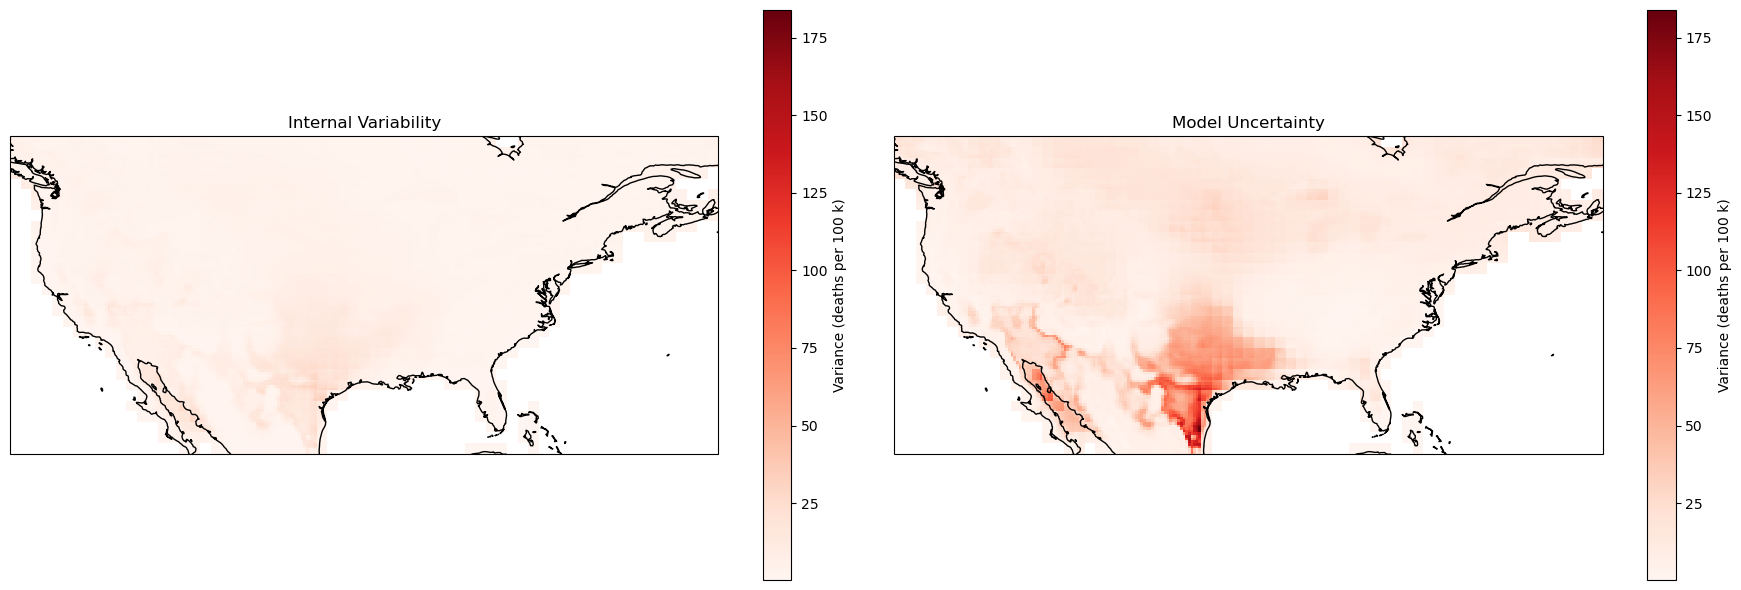

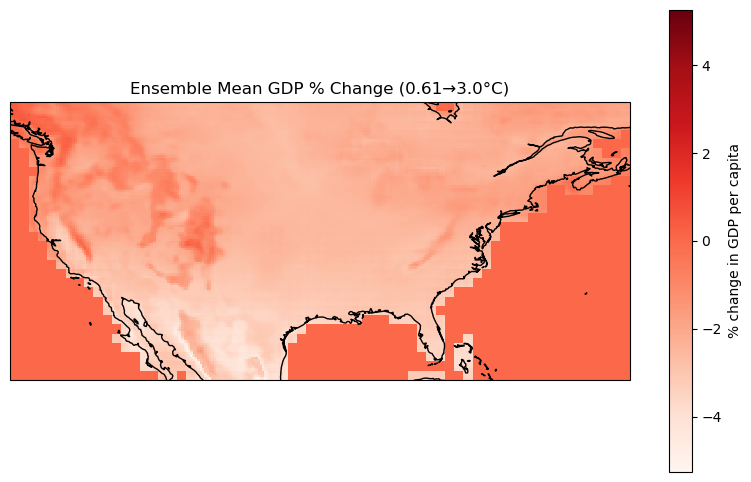

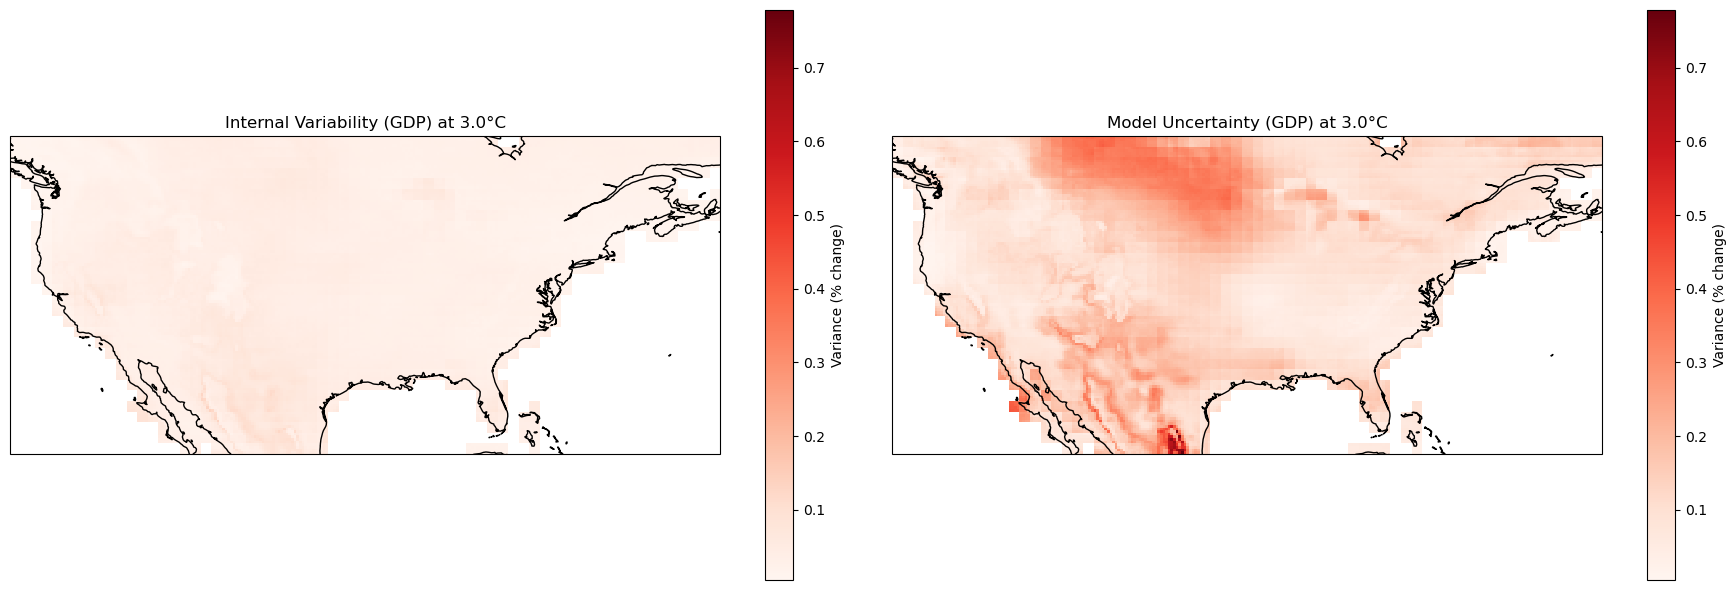

In [83]:
results_3 = spit_out(3.0)

In [48]:
#for each impact map (gdp or mortality), this function caclulates the fractional uncertainty, either 
#model or internal, similarly to the var partitioning function.

def var_table(impact_map, g):
    impact_map = impact_map.where(impact_map !=0)
    ds_glob = area_mean(impact_map.to_dataset(name="impact"))
    impact_glob = ds_glob["impact"]
    
    internal_var = (impact_glob.groupby("model").var(dim="run", ddof=0, skipna=True).mean(dim="model", skipna = True))
    model_var = (impact_glob.groupby("model").mean(dim="run", skipna=True).var(dim="model", ddof=0, skipna=True))
    total = internal_var + model_var
    f_internal = xr.where(total > 0,internal_var / total,0.0).compute().item()
    f_model    = xr.where(total > 0,model_var    / total,0.0).compute().item()

    return {"gwl": g, "f_internal": f_internal, "f_model": f_model}


In [49]:
#This function creates a table of fractional shares of uncertainty from model and internal variances
#by looping through the included GWLs in the dataset, and using the var_table() function to calculate
#fractional uncertainty. 
def global_variability_table(gwl_list):
    rows_mort = []
    rows_gdp  = []

    for g in gwl_list:
        mort_all, gdp_all = calculate_impactt(g)

        rows_mort.append(var_table(mort_all, g))
        rows_gdp.append( var_table(gdp_all,  g))

    mort_df = pd.DataFrame(rows_mort)
    gdp_df  = pd.DataFrame(rows_gdp)
    
    return mort_df, gdp_df

gwl_list = [1.0, 1.5, 2.0, 2.5, 3.0]
mort_df, gdp_df = global_variability_table(gwl_list)

print("Mortality fractions by GWL:")
print(mort_df)

print("\nGDP fractions by GWL:")
print(gdp_df)


/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(

Mortality fractions by GWL:
   gwl  f_internal   f_model
0  1.0    0.575697  0.424303
1  1.5    0.440232  0.559768
2  2.0    0.208426  0.791574
3  2.5    0.161265  0.838735
4  3.0    0.107334  0.892666

GDP fractions by GWL:
   gwl  f_internal   f_model
0  1.0    0.502662  0.497338
1  1.5    0.535638  0.464362
2  2.0    0.408623  0.591377
3  2.5    0.316119  0.683881
4  3.0    0.218661  0.781339
